Subjects amount:  110
Long trials:  55
NaN trials:  326
Total trials:  12048
   mss        rt  accuracy
0  1.0  2.464767       1.0
1  2.0  2.880758       1.0
2  4.0  2.954920       1.0
3  8.0  2.899339       1.0


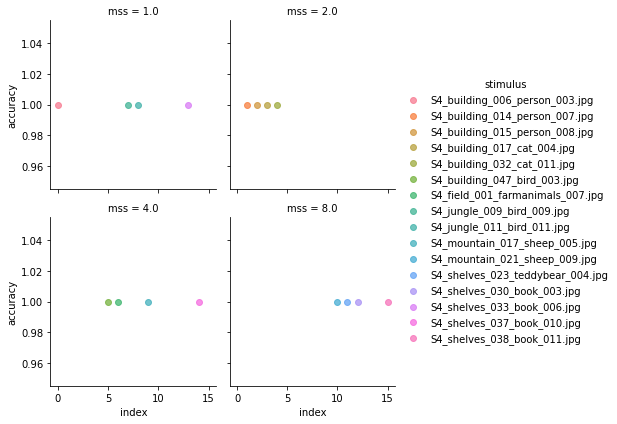

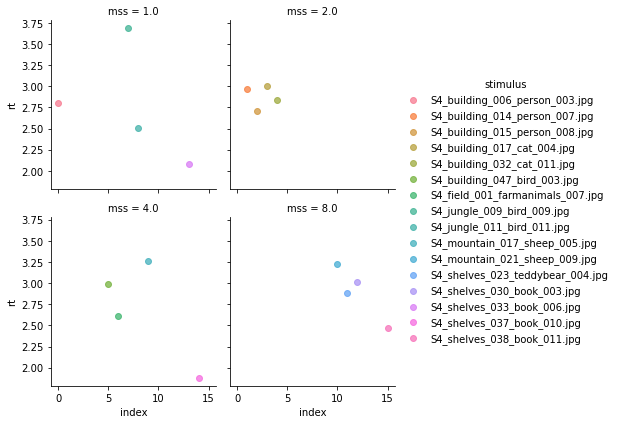

In [2]:
import os
import pandas as pd


folder_path = os.path.join("..","Data","Preprocessed")
# Get all the files in the folder
files = os.listdir(folder_path)
# Iterate through all the files and save the data in a pandas dataframe
data = pd.DataFrame()
subjects_amount = 0
long_trials = 0
nan_trials = 0
for file in files:
    if file.endswith('.csv') or file.endswith('.xlsx'):
        file_data = pd.read_csv(os.path.join(folder_path, file)) if file.endswith('.csv') else pd.read_excel(os.path.join(folder_path, file))
        file_data = file_data[['CONTEXT', 'TARGET', 'MEM_SET_SIZE', 'VISUAL_SET_SIZE', 'key_resp.rt', 'key_resp.corr','FILE_SEARCH_IMAGE']]
        file_data.columns = ['context_present', 'target_present', 'mss', 'vss', 'rt', 'correct_response','stimulus']
        # Add a column with the subject number
        file_data['subject'] = subjects_amount
        # Remove rows where the rt is NaN
        nan_trials += len(file_data[file_data.rt.isna()])
        file_data = file_data[file_data.rt.notna()]
        # Remove rows where the rt > 7 seconds, and add them to the long_trials variable
        long_trials += len(file_data[file_data.rt > 7.0])
        file_data = file_data[file_data.rt <= 7.0]
        # Append the data from the file to the dataframe if it passes the accuracy filter
        if file_data.correct_response.mean() >= 0.55:
            #use concat instead of append
            data = pd.concat([data, file_data])
            subjects_amount += 1

# Filter correct responses
correct_data = data[data.correct_response == 1]
print('Subjects amount: ', subjects_amount)
print('Long trials: ', long_trials)
print('NaN trials: ', nan_trials)
print('Total trials: ', len(data))
# I want to group the rts and accuracy by stimulus, and i only want those that have VSS = 4 and context present = 1
# So first filter the data
data_of_interest = correct_data[(correct_data.vss == 4) & (correct_data.context_present == 1) & (correct_data.target_present == 0)]
# Then group the data by stimulus and get the mean rt and accuracy, but i also want to keep the MSS column
data_of_interest = data_of_interest.groupby(['stimulus', 'mss']).agg({'rt': 'mean', 'correct_response': 'mean'}).reset_index()
# rename the correct_response column to accuracy
data_of_interest = data_of_interest.rename(columns={'correct_response': 'accuracy'})
# With this new data, for each MSS i want a plot of the accuracy and rt for each stimulus, but because the stimulus names are long, i want to use the index of the dataframe as the x axis
# So first i need to create a column with the index of the dataframe
data_of_interest['index'] = data_of_interest.index
# Then i can plot the data, remember that i want the data divided by mss in the same plot, so i need to use the facetgrid
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(data_of_interest, col="mss", hue="stimulus", col_wrap=2)
g.map(plt.scatter, "index", "accuracy", alpha=.7)
g.add_legend()

# Now the same for the rt
g = sns.FacetGrid(data_of_interest, col="mss", hue="stimulus", col_wrap=2)
g.map(plt.scatter, "index", "rt", alpha=.7)
# I want g.add_legend() to be outside the plots, so i need to use plt.show() and plt.close() to close the plots

g.add_legend()

# I would like the mean of each plot in the title, so i need to get the mean of each plot
# First i need to remove the stimulus column and the compute the mean grouped by mss
# Remove row with column index = 7,14,15 (which are the indexes of the stimuli that are too difficult or too easy)
data_of_interest = data_of_interest[data_of_interest.index != 7]
data_of_interest = data_of_interest[data_of_interest.index != 14]

data_of_interest = data_of_interest.drop(columns=['stimulus', 'index'])
data_of_interest = data_of_interest.groupby('mss').mean().reset_index()

print(data_of_interest)

plt.show()
plt.close()


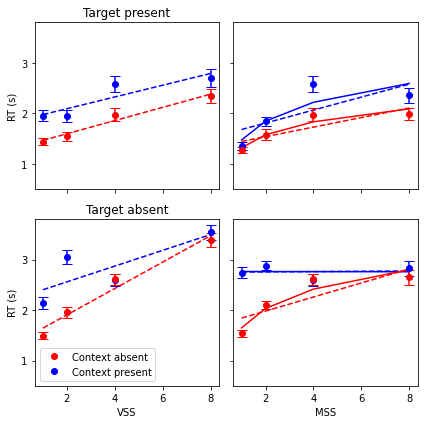

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from scipy.stats import t

VSS = np.array([1, 2, 4, 8])
MSS = np.array([1, 2, 4, 8])



fig, axs = plt.subplots(2, 2, figsize=(6,6), sharex=True, sharey=True)

# I need a ParameterGrid to iterate over all possible combinations of parameters
grid_1 = ParameterGrid({'mss': [4], 'context_present': [True, False], 'target_present': [True, False]})
grid_2 = ParameterGrid({'vss': [4], 'context_present': [True, False], 'target_present': [True, False]})
# I need a dictionary saying in which subplot to plot each condition
# For grid_1, target present goes in the first row and the first column, target absent goes in the second row and the first column
# For grid_2, target present goes in the first row and the second column, target absent goes in the second row and the second column
grid_1_subplot_dict = {'target_present': {True: axs[0, 0], False: axs[1, 0]}}
grid_2_subplot_dict = {'target_present': {True: axs[0, 1], False: axs[1, 1]}}
color = {False: 'red', True: 'blue'}
# In grid_1 I iterate over VSS, in grid_2 I iterate over MSS
# First I iterate over grid_1 to get the mean and 95% CI of the rt for each combination of context_present, target_present, mss and vss of the subjects




for condition in grid_1:
    RT_means = []
    RT_intervals = []
    
    for vss in VSS:

        condition['vss'] = vss
        # I need to filter the dataframe to get only the rows that match the condition
        filtered_data = correct_data[(correct_data.context_present == condition['context_present']) & (correct_data.target_present == condition['target_present']) & (correct_data.mss == condition['mss']) & (correct_data.vss == condition['vss'])]

        RT_means.append(filtered_data.rt.mean())
        ts = t.ppf([0.025,0.975], filtered_data.rt.size-1)
        RT_intervals.append(ts[1]*filtered_data.rt.std()/np.sqrt(filtered_data.rt.size))


    grid_1_subplot_dict['target_present'][condition['target_present']].errorbar(VSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    # Plot the linear regression with dotted lines
    grid_1_subplot_dict['target_present'][condition['target_present']].plot(VSS, np.poly1d(np.polyfit(VSS, RT_means, 1))(VSS), '--', color=color[condition['context_present']])

colors = ["red","blue","green","orange"]
# create handles list with lines using the colors
handles = [plt.Line2D([],[],color=colors[i], marker='o', linestyle='None') for i in range(len(colors))]
for condition in grid_2:
    RT_means = []
    RT_intervals = []
    
    for mss in MSS:

        condition['mss'] = mss
        filtered_data = correct_data[(correct_data.context_present == condition['context_present']) & (correct_data.target_present == condition['target_present']) & (correct_data.mss == condition['mss']) & (correct_data.vss == condition['vss'])]

        RT_means.append(filtered_data.rt.mean())
        ts = t.ppf([0.025,0.975], filtered_data.rt.size-1)
        RT_intervals.append(ts[1]*filtered_data.rt.std()/np.sqrt(filtered_data.rt.size))



    grid_2_subplot_dict['target_present'][condition['target_present']].errorbar(MSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    grid_2_subplot_dict['target_present'][condition['target_present']].plot(MSS, np.poly1d(np.polyfit(MSS, RT_means, 1))(MSS), '--', color=color[condition['context_present']])
    #Plot logaritmic fit
    grid_2_subplot_dict['target_present'][condition['target_present']].plot(MSS, np.poly1d(np.polyfit(np.log(MSS), RT_means, 1))(np.log(MSS)), color=color[condition['context_present']])


axs[0, 0].set_ylabel('RT (s)')
axs[1, 0].set_ylabel('RT (s)')
axs[1, 0].set_xlabel('VSS')
axs[1, 1].set_xlabel('MSS')
axs[1,0].legend(handles=handles,labels=['Context absent', 'Context present'])
#Show in the plots that the first row is for target present and the second row is for target absent
axs[0, 0].set_title('Target present')
axs[1, 0].set_title('Target absent')
axs[0, 0].set_ylim(0.5, 3.8)
axs[0, 0].set_yticks([1, 2, 3])
axs[1, 0].set_ylim(0.5, 3.8)
axs[1, 0].set_yticks([1, 2, 3])
plt.tight_layout()
plt.show()
plt.close()

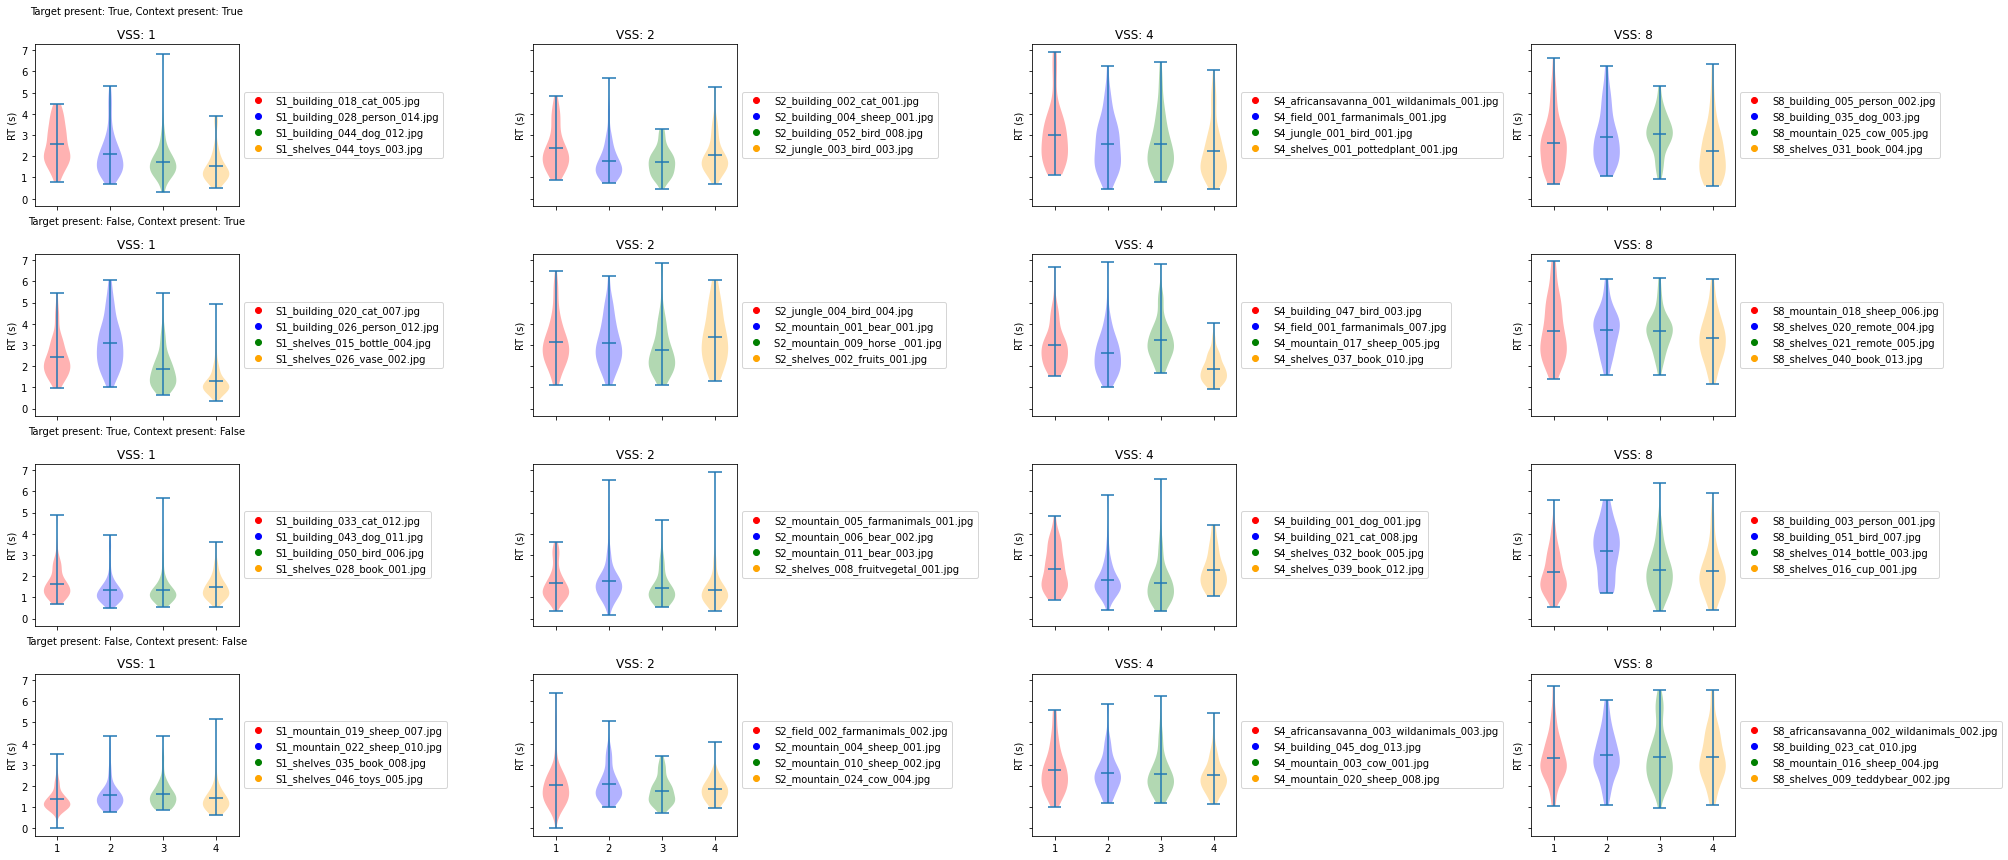

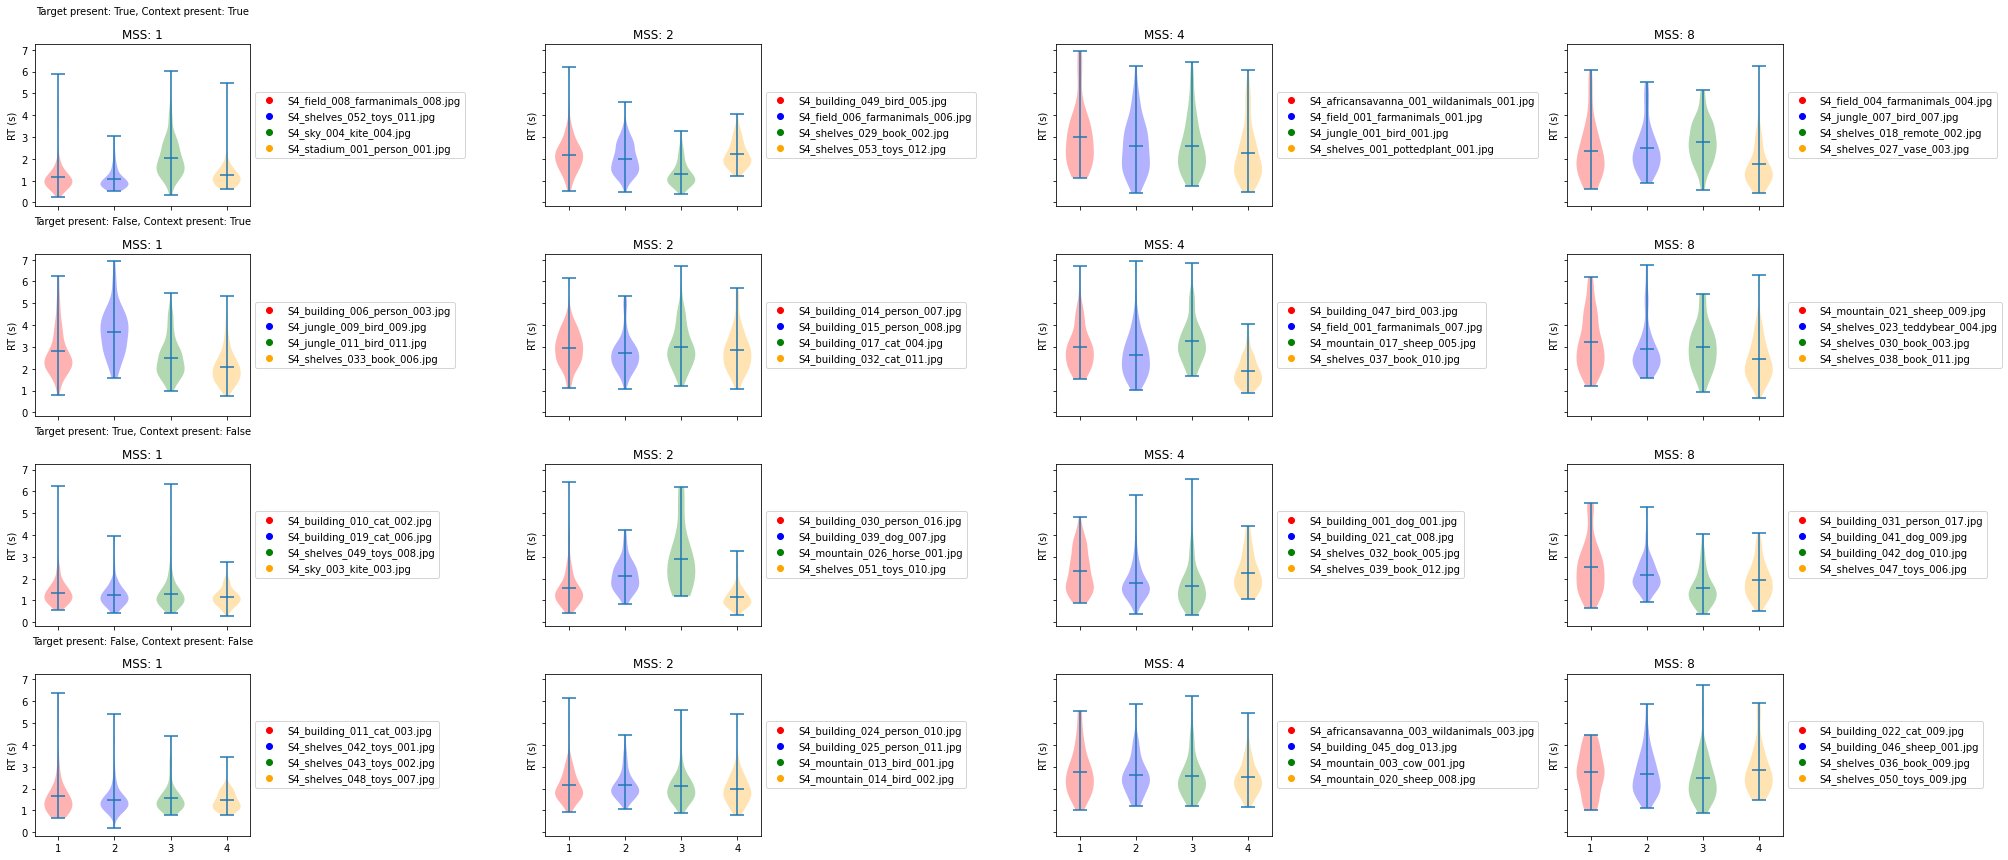

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

VSS = np.array([1, 2, 4, 8])
MSS = np.array([1, 2, 4, 8])

# I need a ParameterGrid to iterate over all possible combinations of parameters
grid_1 = ParameterGrid({'mss': [4], 'context_present': [True, False], 'target_present': [True, False]})
grid_2 = ParameterGrid({'vss': [4], 'context_present': [True, False], 'target_present': [True, False]})
# I need a dictionary saying in which subplot to plot each condition


# I have 4 conditions, and for each condition I have 4 MSS, so I need 4 subplots per condition, and I need 4 rows of subplots
fig, axs = plt.subplots(4, 4, figsize=(28,12), sharex=True, sharey=True)



# I need a dictionary saying in which subplot to plot each condition.
# In column 0 I have target present and context present, in column 1 I have target present and context absent, in column 2 I have target absent and context present, in column 3 I have target absent and context absent
# That means a True and a True = 0, a True and a False = 1, a False and a True = 2, a False and a False = 3
# In row 0 I have MSS = 1, in row 1 I have MSS = 2, in row 2 I have MSS = 4, in row 3 I have MSS = 8 that's for grid 2 and for grid 1 it's the same but with VSS instead of MSS
map_condition_to_column = {True: {True: 0, False: 1}, False: {True: 2, False: 3}}



# In grid_1 I iterate over VSS, in grid_2 I iterate over MSS

for condition in grid_1:
    RT_means = []
    RT_intervals = []
    column_index = map_condition_to_column[condition['context_present']][condition['target_present']]
    axs[column_index][0].text(0.5, 1.2, f'Target present: {condition["target_present"]}, Context present: {condition["context_present"]}', horizontalalignment='center', verticalalignment='center', transform=axs[column_index][0].transAxes)
    dict_stimuli_names_for_mss = {0:[], 1:[], 2:[], 3:[]}
    for vss in VSS:

        condition['vss'] = vss
        # I need to filter the dataframe to get only the rows that match the condition
        filtered_data = correct_data[(correct_data.context_present == condition['context_present']) & (correct_data.target_present == condition['target_present']) & (correct_data.mss == condition['mss']) & (correct_data.vss == condition['vss'])]
        #order by stimulus and reset the index
        filtered_data = filtered_data.sort_values(by=['stimulus']).reset_index(drop=True)

        # I want to do a boxplot of the rt for each stimulus in the condition
        unique_stimuli = filtered_data.stimulus.unique()
        
        stimuli_color_mapping = {unique_stimuli[i]: colors[i] for i in range(len(unique_stimuli))}
        color_list = [stimuli_color_mapping[stimulus] for stimulus in filtered_data.stimulus]
        index_of_mss_in_MSS = np.where(VSS == vss)[0][0]
        # group rts by stimulus, and place them in a list
        rts_by_stimulus = [filtered_data.rt[filtered_data.stimulus == stimulus] for stimulus in unique_stimuli]
        
        
        boxplots = axs[column_index][index_of_mss_in_MSS].violinplot(rts_by_stimulus, showmeans=True)



        #set the color of the violinplot
        for patch, color_ in zip(boxplots['bodies'], colors):
            patch.set_facecolor(color_)

        #set the title of the plot to the condition
        axs[column_index][index_of_mss_in_MSS].set_title(f'VSS: {vss}')
        #set the x axis label and y axis label
        axs[column_index][index_of_mss_in_MSS].set_ylabel('RT (s)')
        dict_stimuli_names_for_mss[index_of_mss_in_MSS] = list(unique_stimuli)
    for key,value in dict_stimuli_names_for_mss.items():
        # set the legend of the corresponding axs_ plot, next to the plot
        axs[column_index][key].legend(handles,value,  loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
# I have 4 conditions, and for each condition I have 4 VSS, so I need 4 subplots per condition, and I need 4 rows of subplots
fig_,axs_ = plt.subplots(4, 4, figsize=(28,12), sharex=True, sharey=True)

# create handles list with lines using the colors

for condition in grid_2:
    RT_means = []
    RT_intervals = []
    column_index = map_condition_to_column[condition['context_present']][condition['target_present']]
    # Place the name of the condition in the corresponding subplot, but with a text box
    axs_[column_index][0].text(0.5, 1.2, f'Target present: {condition["target_present"]}, Context present: {condition["context_present"]}', horizontalalignment='center', verticalalignment='center', transform=axs_[column_index][0].transAxes)
    dict_stimuli_names_for_mss = {0:[], 1:[], 2:[], 3:[]}    
    for mss in MSS:

        condition['mss'] = mss
        filtered_data = correct_data[(correct_data.context_present == condition['context_present']) & (correct_data.target_present == condition['target_present']) & (correct_data.mss == condition['mss']) & (correct_data.vss == condition['vss'])]
        #order by stimulus and reset the index
        filtered_data = filtered_data.sort_values(by=['stimulus']).reset_index(drop=True)

        # I want to do a boxplot of the rt for each stimulus in the condition
        unique_stimuli = filtered_data.stimulus.unique()
        
        stimuli_color_mapping = {unique_stimuli[i]: colors[i] for i in range(len(unique_stimuli))}
        color_list = [stimuli_color_mapping[stimulus] for stimulus in filtered_data.stimulus]
        index_of_mss_in_MSS = np.where(MSS == mss)[0][0]
        # group rts by stimulus, and place them in a list
        rts_by_stimulus = [filtered_data.rt[filtered_data.stimulus == stimulus] for stimulus in unique_stimuli]
        
        
        boxplots = axs_[column_index][index_of_mss_in_MSS].violinplot(rts_by_stimulus, showmeans=True)



        #set the color of the violinplot
        for patch, color_ in zip(boxplots['bodies'], colors):
            patch.set_facecolor(color_)

        #set the title of the plot to the condition
        axs_[column_index][index_of_mss_in_MSS].set_title(f'MSS: {mss}')
        #set the x axis label and y axis label
        axs_[column_index][index_of_mss_in_MSS].set_ylabel('RT (s)')
        dict_stimuli_names_for_mss[index_of_mss_in_MSS] = list(unique_stimuli)
    for key,value in dict_stimuli_names_for_mss.items():
        # set the legend of the corresponding axs_ plot, next to the plot
        axs_[column_index][key].legend(handles,value,  loc='center left', bbox_to_anchor=(1, 0.5))


plt.tight_layout()
plt.show()
plt.close()

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools


results_dataframe = pd.DataFrame(columns=['MSS', 'VSS', 'context_present', 'target_present', 'F stimulus', 'p-value stimulus','F stimulus filtered', 'p-value stimulus filtered'])
stimuli_to_reject = []

for condition in grid_2:
    for mss in MSS:
        filtered_data = correct_data[(correct_data.context_present == condition['context_present']) & (correct_data.target_present == condition['target_present']) & (correct_data.mss == mss) & (correct_data.vss == 4)]
        # Fit the ANOVA model
        model = ols('rt ~ stimulus', data=filtered_data).fit()

        # Create ANOVA table
        anova_table = sm.stats.anova_lm(model, typ=2)
        # add the results to the dataframe using concat
        results_dataframe = pd.concat([results_dataframe, pd.DataFrame([[mss, 4, condition['context_present'], condition['target_present'], anova_table['F']['stimulus'], anova_table['PR(>F)']['stimulus']]], columns=['MSS', 'VSS', 'context_present', 'target_present', 'F stimulus', 'p-value stimulus'])])
        # Filter the rts to those in which the F stimulus is > 20 and the p-value stimulus is < 0.05
        if anova_table['F']['stimulus'] > 20 and anova_table['PR(>F)']['stimulus'] < 0.05:
            posthoc = pairwise_tukeyhsd(filtered_data['rt'], filtered_data['stimulus'], alpha=0.05)
            reject_indexes = posthoc.reject
            mean_per_stimulus = dict(zip(posthoc.groupsunique, np.zeros(len(posthoc.groupsunique))))
            combination_pairwise_stimulus = np.array(list(itertools.combinations(posthoc.groupsunique, 2)))[reject_indexes]
            
            mean_diffs = np.abs(posthoc.meandiffs)[reject_indexes]
            for i in range(len(combination_pairwise_stimulus)):
                mean_per_stimulus[combination_pairwise_stimulus[i][0]] += mean_diffs[i]
                mean_per_stimulus[combination_pairwise_stimulus[i][1]] += mean_diffs[i]

            # get the stimulus with maximum mean difference, if it is greater than 0 append it to the stimuli_to_reject list
            max_mean_difference = max(mean_per_stimulus.values())
            if max_mean_difference > 0:
                stimuli_to_reject.append(list(mean_per_stimulus.keys())[list(mean_per_stimulus.values()).index(max_mean_difference)])
            filtered_data = filtered_data[~filtered_data.stimulus.isin(stimuli_to_reject)]
            # Fit the ANOVA model
            model = ols('rt ~ stimulus', data=filtered_data).fit()
            # Create ANOVA table
            anova_table = sm.stats.anova_lm(model, typ=2)
        # add the results to the columns F stimulus filtered and p-value stimulus filtered
        results_dataframe.loc[(results_dataframe['MSS'] == mss) & (results_dataframe['VSS'] == 4) & (results_dataframe['context_present'] == condition['context_present']) & (results_dataframe['target_present'] == condition['target_present']), 'F stimulus filtered'] = anova_table['F']['stimulus']
        results_dataframe.loc[(results_dataframe['MSS'] == mss) & (results_dataframe['VSS'] == 4) & (results_dataframe['context_present'] == condition['context_present']) & (results_dataframe['target_present'] == condition['target_present']), 'p-value stimulus filtered'] = anova_table['PR(>F)']['stimulus']



for condition in grid_1:
    for vss in VSS:
        filtered_data = correct_data[(correct_data.context_present == condition['context_present']) & (correct_data.target_present == condition['target_present']) & (correct_data.mss == 4) & (correct_data.vss == vss)]
        # Fit the ANOVA model
        model = ols('rt ~ stimulus', data=filtered_data).fit()
        # Create ANOVA table
        anova_table = sm.stats.anova_lm(model, typ=1)
        # add the results to the dataframe using concat
        results_dataframe = pd.concat([results_dataframe, pd.DataFrame([[4, vss, condition['context_present'], condition['target_present'], anova_table['F']['stimulus'], anova_table['PR(>F)']['stimulus'] ]], columns=['MSS', 'VSS', 'context_present', 'target_present', 'F stimulus', 'p-value stimulus'])])
        # Filter the rts to those in which the F stimulus is > 20 and the p-value stimulus is < 0.05
        if anova_table['F']['stimulus'] > 20 and anova_table['PR(>F)']['stimulus'] < 0.05:
            posthoc = pairwise_tukeyhsd(filtered_data['rt'], filtered_data['stimulus'], alpha=0.05)
            reject_indexes = posthoc.reject
            mean_per_stimulus = dict(zip(posthoc.groupsunique, np.zeros(len(posthoc.groupsunique))))
            combination_pairwise_stimulus = np.array(list(itertools.combinations(posthoc.groupsunique, 2)))[reject_indexes]        
            mean_diffs = np.abs(posthoc.meandiffs)[reject_indexes]
            for i in range(len(combination_pairwise_stimulus)):
                mean_per_stimulus[combination_pairwise_stimulus[i][0]] += mean_diffs[i]
                mean_per_stimulus[combination_pairwise_stimulus[i][1]] += mean_diffs[i]

            # get the stimulus with maximum mean difference, if it is greater than 0 append it to the stimuli_to_reject list
            max_mean_difference = max(mean_per_stimulus.values())
            # get the key of the maximum value
            if max_mean_difference > 0:
                stimuli_to_reject.append(list(mean_per_stimulus.keys())[list(mean_per_stimulus.values()).index(max_mean_difference)])
            filtered_data = filtered_data[~filtered_data.stimulus.isin(stimuli_to_reject)]
            # Fit the ANOVA model
            model = ols('rt ~ stimulus', data=filtered_data).fit()
            # Create ANOVA table
            anova_table = sm.stats.anova_lm(model, typ=2)
        # add the results to the columns F stimulus filtered and p-value stimulus filtered
        results_dataframe.loc[(results_dataframe['MSS'] == 4) & (results_dataframe['VSS'] == vss) & (results_dataframe['context_present'] == condition['context_present']) & (results_dataframe['target_present'] == condition['target_present']), 'F stimulus filtered'] = anova_table['F']['stimulus']
        results_dataframe.loc[(results_dataframe['MSS'] == 4) & (results_dataframe['VSS'] == vss) & (results_dataframe['context_present'] == condition['context_present']) & (results_dataframe['target_present'] == condition['target_present']), 'p-value stimulus filtered'] = anova_table['PR(>F)']['stimulus']
        

stimuli_to_reject = list(set(stimuli_to_reject))
print(stimuli_to_reject)
data = data[~data.stimulus.isin(stimuli_to_reject)]
correct_data = correct_data[~correct_data.stimulus.isin(stimuli_to_reject)]
results_dataframe

/tmp/ipykernel_29754/34431095.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_dataframe = pd.concat([results_dataframe, pd.DataFrame([[mss, 4, condition['context_present'], condition['target_present'], anova_table['F']['stimulus'], anova_table['PR(>F)']['stimulus']]], columns=['MSS', 'VSS', 'context_present', 'target_present', 'F stimulus', 'p-value stimulus'])])


['S4_jungle_009_bird_009.jpg', 'S4_sky_004_kite_004.jpg', 'S4_shelves_037_book_010.jpg', 'S4_mountain_026_horse_001.jpg', 'S1_building_026_person_012.jpg', 'S4_shelves_029_book_002.jpg']


,MSS,VSS,context_present,target_present,F stimulus,p-value stimulus,F stimulus filtered,p-value stimulus filtered
0,1,4,True,True,35.828671,1.597662e-20,2.770075,0.064199
0,2,4,True,True,30.343716,3.862623e-17,1.450456,0.236982
0,4,4,True,True,4.007796,8.194179e-03,4.007796,0.008194
0,8,4,True,True,11.960209,2.402961e-07,11.960209,0.0
0,1,4,True,False,46.345252,1.086193e-25,15.231214,0.0
0,2,4,True,False,2.141048,9.450552e-02,2.141048,0.094506
0,4,4,True,False,35.923042,5.607254e-20,6.820271,0.001345
0,8,4,True,False,5.966232,6.095248e-04,5.966232,0.00061
0,1,4,False,True,2.285821,7.826516e-02,2.285821,0.078265
0,2,4,False,True,30.527820,6.768534e-17,29.370312,0.0


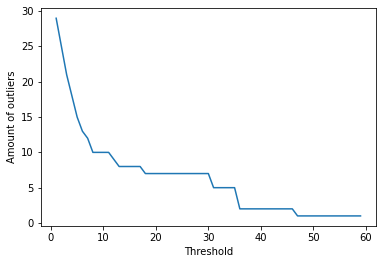

In [6]:
from matplotlib import pyplot as plt
import numpy as np
data = [
    35.828671,
    30.343716,
    4.007796,
    11.960209,
    46.345252,
    2.141048,
    35.923042,
    5.966232,
    2.285821,
    30.52782,
    7.943087,
    12.646677,
    1.261235,
    1.316675,
    0.704047,
    1.44246,
    17.566722,
    5.20741,
    4.007796,
    3.761058,
    67.896876,
    3.435683,
    35.923042,
    1.627968,
    3.186468,
    4.16674,
    7.943087,
    6.756027,
    2.44576,
    2.104972,
    0.704047,
    0.087171
]
# Plot a function of the amount of outliers as a function of the threshold using these values (the threshold should go from 1 to 60)
thresholds = np.arange(1, 60)
outliers = []
for threshold in thresholds:
    outliers.append(len([value for value in data if value > threshold]))
plt.xlabel('Threshold')
plt.ylabel('Amount of outliers')
plt.plot(thresholds, outliers)